In [2]:
 !pip install -q scikit-learn pandas numpy matplotlib seaborn scipy

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import cross_val_score, KFold
from sklearn.preprocessing import RobustScaler, LabelEncoder
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)
%matplotlib inline

os.makedirs('/content/outputs', exist_ok=True)

train = pd.read_csv('/content/train.csv')
test = pd.read_csv('/content/test.csv')

print('Data loaded successfully!')
print(f'Train shape: {train.shape}')
print(f'Test shape: {test.shape}')

Data loaded successfully!
Train shape: (1460, 81)
Test shape: (1459, 80)


In [4]:
print(f'Target variable (SalePrice) statistics:')
print(train['SalePrice'].describe())
print(f'\nMissing values:')
missing = train.isnull().sum()
print(missing[missing > 0].sort_values(ascending=False))

Target variable (SalePrice) statistics:
count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

Missing values:
PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
MasVnrType       872
FireplaceQu      690
LotFrontage      259
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
BsmtExposure      38
BsmtFinType2      38
BsmtQual          37
BsmtCond          37
BsmtFinType1      37
MasVnrArea         8
Electrical         1
dtype: int64


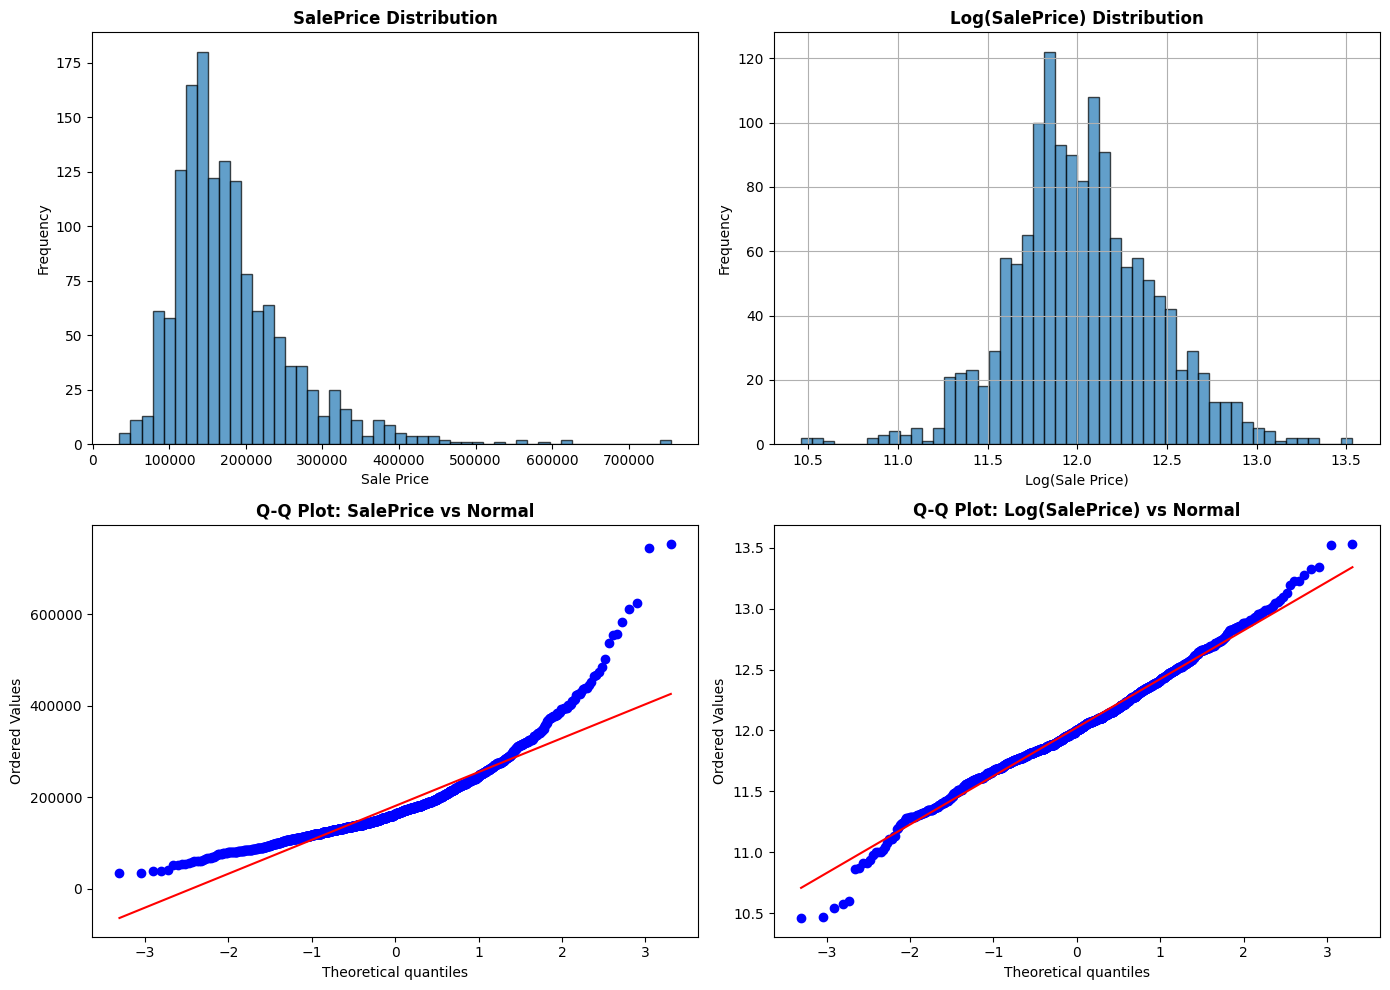

Skewness (original): 1.883
Skewness (log): 0.121


In [5]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

axes[0, 0].hist(train['SalePrice'], bins=50, edgecolor='black', alpha=0.7)
axes[0, 0].set_title('SalePrice Distribution', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Sale Price')
axes[0, 0].set_ylabel('Frequency')

np.log1p(train['SalePrice']).hist(bins=50, ax=axes[0, 1], edgecolor='black', alpha=0.7)
axes[0, 1].set_title('Log(SalePrice) Distribution', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Log(Sale Price)')
axes[0, 1].set_ylabel('Frequency')

stats.probplot(train['SalePrice'], dist='norm', plot=axes[1, 0])
axes[1, 0].set_title('Q-Q Plot: SalePrice vs Normal', fontsize=12, fontweight='bold')

stats.probplot(np.log1p(train['SalePrice']), dist='norm', plot=axes[1, 1])
axes[1, 1].set_title('Q-Q Plot: Log(SalePrice) vs Normal', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('/content/outputs/01_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print(f'Skewness (original): {train["SalePrice"].skew():.3f}')
print(f'Skewness (log): {np.log1p(train["SalePrice"]).skew():.3f}')

Numeric features: 36
Categorical features: 43


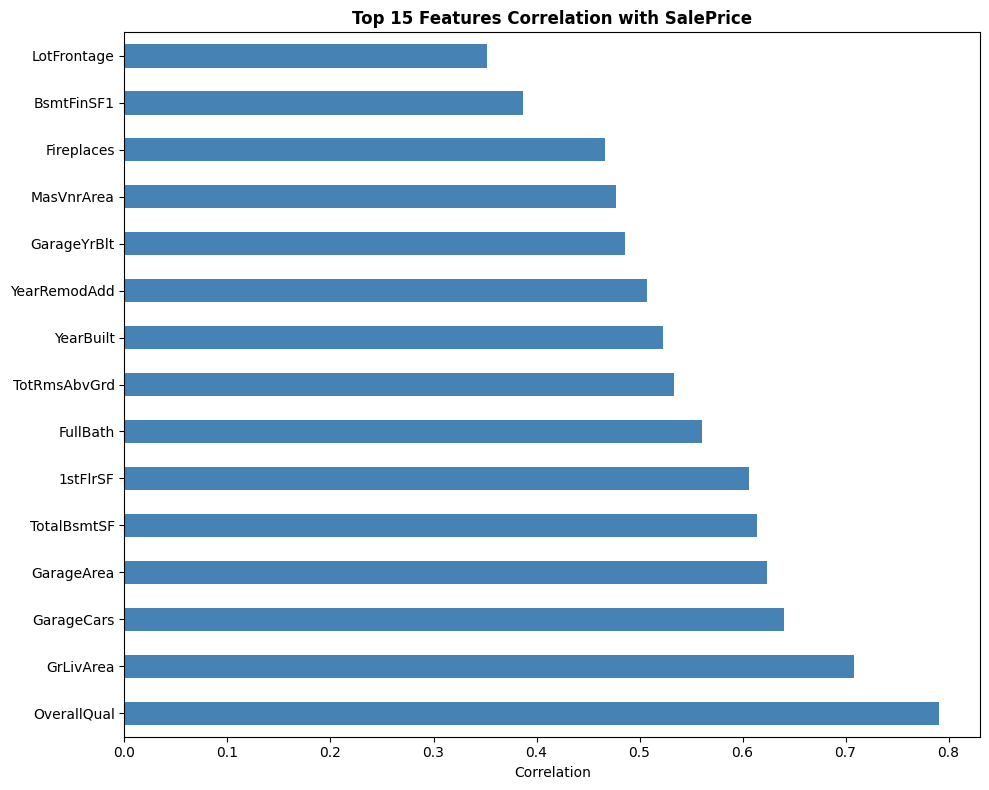


Top 10 correlated features:
OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
YearRemodAdd    0.507101
Name: SalePrice, dtype: float64


In [6]:
numeric_cols = train.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols.remove('Id')
numeric_cols.remove('SalePrice')

categorical_cols = train.select_dtypes(include=['object']).columns.tolist()

print(f'Numeric features: {len(numeric_cols)}')
print(f'Categorical features: {len(categorical_cols)}')

correlations = train[numeric_cols + ['SalePrice']].corr()['SalePrice'].sort_values(ascending=False)
top_corr = correlations.iloc[1:16]

fig, ax = plt.subplots(figsize=(10, 8))
top_corr.plot(kind='barh', ax=ax, color='steelblue')
ax.set_title('Top 15 Features Correlation with SalePrice', fontsize=12, fontweight='bold')
ax.set_xlabel('Correlation')
plt.tight_layout()
plt.savefig('/content/outputs/02_correlations.png', dpi=300, bbox_inches='tight')
plt.show()

print('\nTop 10 correlated features:')
print(top_corr.head(10))

In [7]:
y_train_log = np.log1p(train['SalePrice'])

for col in numeric_cols:
    if train[col].isnull().sum() > 0:
        train[col].fillna(train[col].median(), inplace=True)
    if test[col].isnull().sum() > 0:
        test[col].fillna(train[col].median(), inplace=True)

for col in categorical_cols:
    if train[col].isnull().sum() > 0:
        train[col].fillna('NA', inplace=True)
    if test[col].isnull().sum() > 0:
        test[col].fillna('NA', inplace=True)

print(f'Train nulls: {train.isnull().sum().sum()}')
print(f'Test nulls: {test.isnull().sum().sum()}')

Train nulls: 0
Test nulls: 0


In [8]:
def engineer_features(df):
    df = df.copy()
    df['TotalSF'] = df['TotalBsmtSF'] + df['1stFlrSF'] + df['2ndFlrSF']
    df['TotalBathrooms'] = df['BsmtFullBath'] + 0.5 * df['BsmtHalfBath'] + df['FullBath'] + 0.5 * df['HalfBath']
    df['PorchSF'] = df['OpenPorchSF'] + df['3SsnPorch'] + df['EnclosedPorch'] + df['ScreenPorch']
    df['YearsOld'] = 2024 - df['YearBuilt']
    df['YearsRemodeled'] = 2024 - df['YearRemodAdd']
    df['GarageAge'] = df['YearsOld'] - (2024 - df['GarageYrBlt']).clip(lower=0)
    df['HasPool'] = (df['PoolArea'] > 0).astype(int)
    df['HasFireplace'] = (df['Fireplaces'] > 0).astype(int)
    df['GarageCarPerSF'] = df['GarageCars'] / (df['GarageArea'] + 1)
    df['LivingAreaRatio'] = df['GrLivArea'] / (df['TotalSF'] + 1)
    return df

train = engineer_features(train)
test = engineer_features(test)

print('Feature engineering complete')

Feature engineering complete


In [9]:
le_map = {}
for col in categorical_cols:
    le = LabelEncoder()
    combined = pd.concat([train[col], test[col]], ignore_index=True)
    le.fit(combined)
    train[col] = le.transform(train[col])
    test[col] = le.transform(test[col])
    le_map[col] = le

print(f'Encoded {len(categorical_cols)} categorical features')

Encoded 43 categorical features


In [10]:
engineered_cols = ['TotalSF', 'TotalBathrooms', 'PorchSF', 'YearsOld', 'YearsRemodeled', 'GarageAge', 'HasPool', 'HasFireplace', 'GarageCarPerSF', 'LivingAreaRatio']

feature_cols = numeric_cols + categorical_cols + engineered_cols
feature_cols = [col for col in feature_cols if col in train.columns]

X_train = train[feature_cols].copy()
X_test = test[feature_cols].copy()

print(f'Feature matrix shape: {X_train.shape}')

scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=feature_cols)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=feature_cols)

Feature matrix shape: (1460, 89)


In [11]:
models = {
    'Ridge': Ridge(alpha=10.0, random_state=42),
    'Lasso': Lasso(alpha=100.0, random_state=42, max_iter=5000),
    'ElasticNet': ElasticNet(alpha=1.0, l1_ratio=0.5, random_state=42, max_iter=5000),
    'GradientBoosting': GradientBoostingRegressor(n_estimators=200, learning_rate=0.05, max_depth=5, subsample=0.8, random_state=42),
    'RandomForest': RandomForestRegressor(n_estimators=200, max_depth=20, random_state=42, n_jobs=-1)
}

kfold = KFold(n_splits=5, shuffle=True, random_state=42)

print('Cross-validating models...')
for name, model in models.items():
    cv_scores = cross_val_score(model, X_train_scaled, y_train_log, cv=kfold, scoring='neg_mean_squared_error', n_jobs=-1)
    rmse = np.sqrt(-cv_scores)
    print(f'{name:20s} - RMSE: {rmse.mean():.4f} (+/- {rmse.std():.4f})')

Cross-validating models...
Ridge                - RMSE: 0.1591 (+/- 0.0440)
Lasso                - RMSE: 0.3988 (+/- 0.0251)
ElasticNet           - RMSE: 0.3777 (+/- 0.0251)
GradientBoosting     - RMSE: 0.1327 (+/- 0.0207)
RandomForest         - RMSE: 0.1416 (+/- 0.0184)


In [12]:
best_model = GradientBoostingRegressor(n_estimators=200, learning_rate=0.05, max_depth=5, subsample=0.8, random_state=42)
best_model.fit(X_train_scaled, y_train_log)

y_pred_train = best_model.predict(X_train_scaled)
train_rmse = np.sqrt(mean_squared_error(y_train_log, y_pred_train))
train_r2 = r2_score(y_train_log, y_pred_train)

print(f'Training RMSE (log): {train_rmse:.4f}')
print(f'R-squared: {train_r2:.4f}')

Training RMSE (log): 0.0412
R-squared: 0.9894


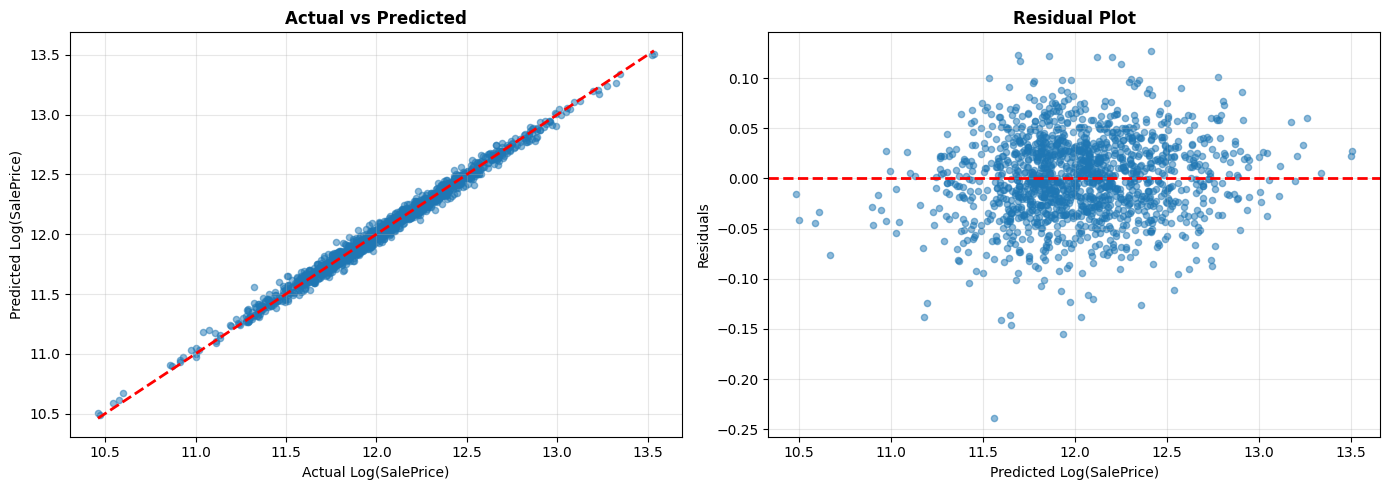

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].scatter(y_train_log, y_pred_train, alpha=0.5, s=20)
axes[0].plot([y_train_log.min(), y_train_log.max()], [y_train_log.min(), y_train_log.max()], 'r--', lw=2)
axes[0].set_xlabel('Actual Log(SalePrice)')
axes[0].set_ylabel('Predicted Log(SalePrice)')
axes[0].set_title('Actual vs Predicted', fontsize=12, fontweight='bold')
axes[0].grid(True, alpha=0.3)

residuals = y_train_log - y_pred_train
axes[1].scatter(y_pred_train, residuals, alpha=0.5, s=20)
axes[1].axhline(y=0, color='r', linestyle='--', lw=2)
axes[1].set_xlabel('Predicted Log(SalePrice)')
axes[1].set_ylabel('Residuals')
axes[1].set_title('Residual Plot', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('/content/outputs/03_diagnostics.png', dpi=300, bbox_inches='tight')
plt.show()

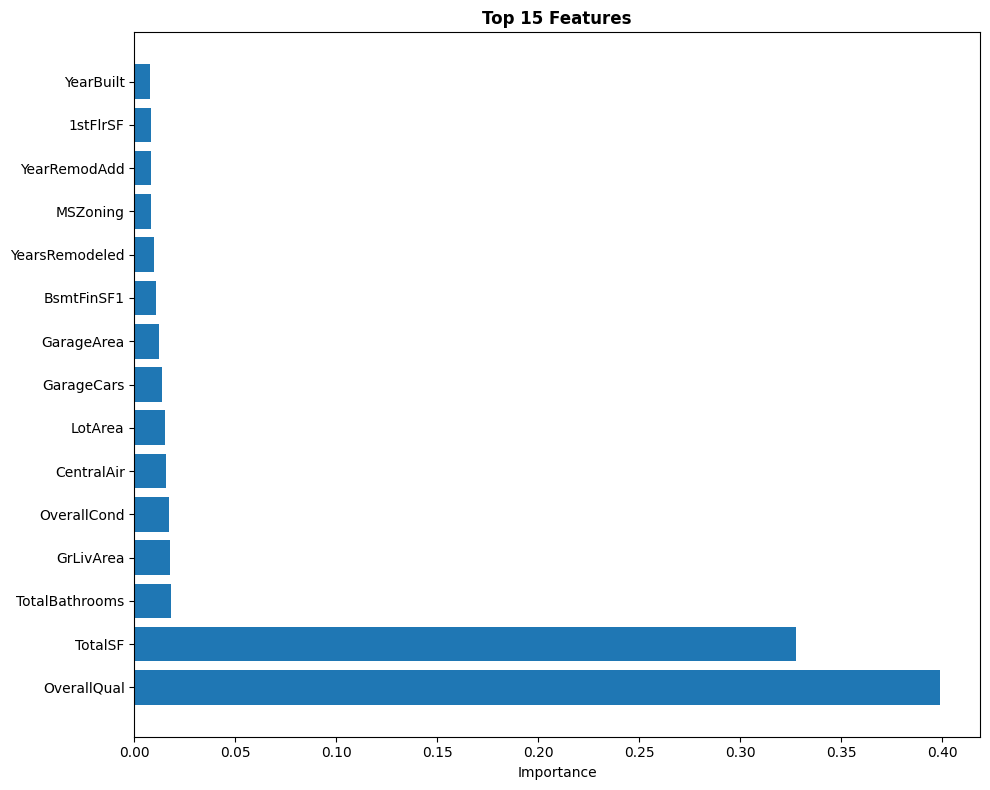

In [14]:
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': best_model.feature_importances_
}).sort_values('importance', ascending=False).head(15)

fig, ax = plt.subplots(figsize=(10, 8))
ax.barh(range(len(feature_importance)), feature_importance['importance'].values)
ax.set_yticks(range(len(feature_importance)))
ax.set_yticklabels(feature_importance['feature'].values)
ax.set_xlabel('Importance')
ax.set_title('Top 15 Features', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.savefig('/content/outputs/04_importance.png', dpi=300, bbox_inches='tight')
plt.show()

In [15]:
y_pred_test_log = best_model.predict(X_test_scaled)
y_pred_test = np.expm1(y_pred_test_log)

submission = pd.DataFrame({
    'Id': test['Id'],
    'SalePrice': y_pred_test
})

submission.to_csv('/content/outputs/submission.csv', index=False)

print(f'Submission created: {submission.shape[0]} predictions')
print(f'Mean price: ${submission["SalePrice"].mean():,.0f}')
print(f'Median price: ${submission["SalePrice"].median():,.0f}')

Submission created: 1459 predictions
Mean price: $177,768
Median price: $156,881


In [19]:
print('\n' + '='*60)
print('FINAL SUMMARY')
print('='*60)
print(f'RMSE (log): {train_rmse:.4f}')
print(f'R² Score: {train_r2:.4f}')
print(f'Features: {X_train_scaled.shape[1]}')
print(f'Training samples: {X_train_scaled.shape[0]}')

print('='*60)


FINAL SUMMARY
RMSE (log): 0.0412
R² Score: 0.9894
Features: 89
Training samples: 1460


In [18]:
from google.colab import files
files.download('/content/outputs/submission.csv')
print('Outputted Files')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Outputted Files
